References:<br>
https://docs.scvi-tools.org/en/stable/tutorials/notebooks/quick_start/api_overview.html

In [1]:
import scanpy as sc
import anndata as ad
import scvi
import seaborn as sns
import torch
import pandas as pd

In [2]:
import os
os.chdir("/dcs04/lieber/lcolladotor/spatialHPC_LIBD4035/spatial_hpc")
os.getcwd()

'/dcs04/lieber/lcolladotor/spatialHPC_LIBD4035/spatial_hpc'

In [3]:
adata = ad.read_h5ad("snRNAseq_hpc/python_analysis/processed-data/adata_qc-strict.h5")
adata #81838

AnnData object with n_obs × n_vars = 81838 × 36601
    obs: 'barcode', 'key', 'sample', 'tissue', 'brnum', 'round', 'sorted', 'id', 'dx', 'race', 'sex', 'age', 'pmi', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'rnd_br_sort'

This python-based [best practices site](https://www.sc-best-practices.org/preprocessing_visualization/feature_selection.html) uses scry::devianceFeatureSelection so I will too.<br>
Although this can be run through a python interface, its easier (for me) to just run it in R. See `code/03_1_devianceFeatureSelection.r`.

In [4]:
rdata = pd.read_csv("snRNAseq_hpc/python_analysis/processed-data/rowData_strict_bin-deviance.csv")
hdgs = rdata.Symbol[0:2000]
#rdata['highly_deviant'] = False
#rdata.loc[0:1999,'highly_deviant'] = True
#rdata.set_index('Symbol', inplace=True)

In [5]:
adata.var['highly_deviant'] = False
adata.var.loc[hdgs,'highly_deviant'] = True

In [6]:
# Saving count data
adata.layers["counts"] = adata.X.copy()

In [7]:
# Subset to highly deviant genes
adata_hdg = adata[:,adata.var["highly_deviant"]]

**Setting up the model**

In [8]:
adata_hdg = adata_hdg.copy() #threw error without this and specifically requested it
scvi.model.SCVI.setup_anndata(
    adata_hdg,
    layer="counts",
    categorical_covariate_keys=["round", "brnum"],
    continuous_covariate_keys=["pct_counts_mt", "age","pmi"],
)

In [9]:
model = scvi.model.SCVI(adata_hdg)

In [10]:
model

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

In [11]:
model.train()

/users/jthompso/.conda/envs/snPy/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /users/jthompso/.conda/envs/snPy/lib/python3.10/site ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/users/jthompso/.conda/envs/snPy/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /users/jthompso/.conda/envs/snPy/lib/python3.10/site ...


Epoch 98/98: 100%|████████████████████████████████████████| 98/98 [34:33<00:00, 21.09s/it, v_num=1, train_loss_step=3.26e+3, train_loss_epoch=3.32e+3]

`Trainer.fit` stopped: `max_epochs=98` reached.


Epoch 98/98: 100%|████████████████████████████████████████| 98/98 [34:33<00:00, 21.16s/it, v_num=1, train_loss_step=3.26e+3, train_loss_epoch=3.32e+3]


In [12]:
model.save("snRNAseq_hpc/python_analysis/processed-data/scvi_model_strict-2k-hdg", overwrite=True)
#model = scvi.model.SCVI.load(model_dir, adata=adata)

In [13]:
latent = model.get_latent_representation()
latent.shape
adata_hdg.obsm['scvi_latent'] = latent

In [14]:
sc.pp.neighbors(adata_hdg, use_rep='scvi_latent')
sc.tl.umap(adata_hdg, min_dist=0.3)

In [15]:
adata_hdg

AnnData object with n_obs × n_vars = 81838 × 2000
    obs: 'barcode', 'key', 'sample', 'tissue', 'brnum', 'round', 'sorted', 'id', 'dx', 'race', 'sex', 'age', 'pmi', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'rnd_br_sort', '_scvi_batch', '_scvi_labels'
    var: 'highly_deviant'
    uns: '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap'
    obsm: '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs', 'scvi_latent', 'X_umap'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

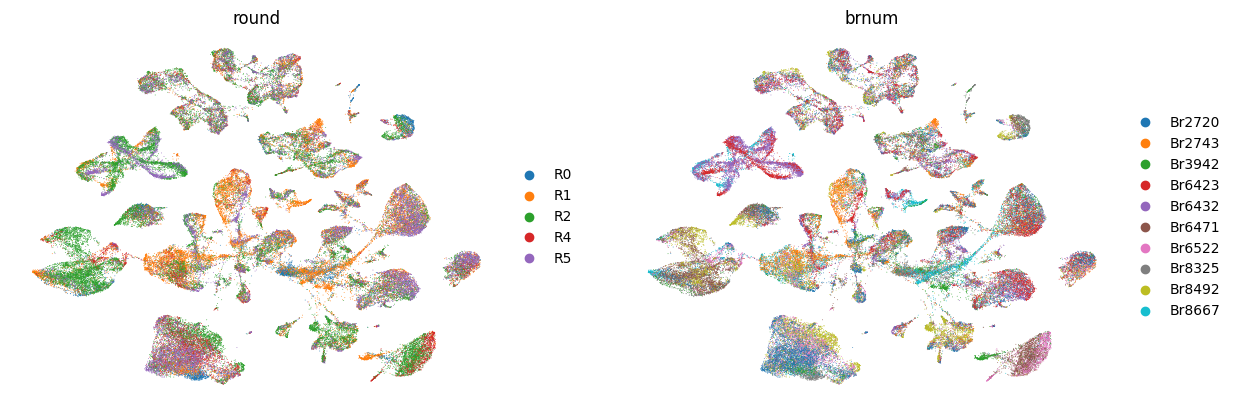

In [16]:
sc.pl.umap(adata_hdg, color=["round", "brnum"], ncols=2, frameon=False)

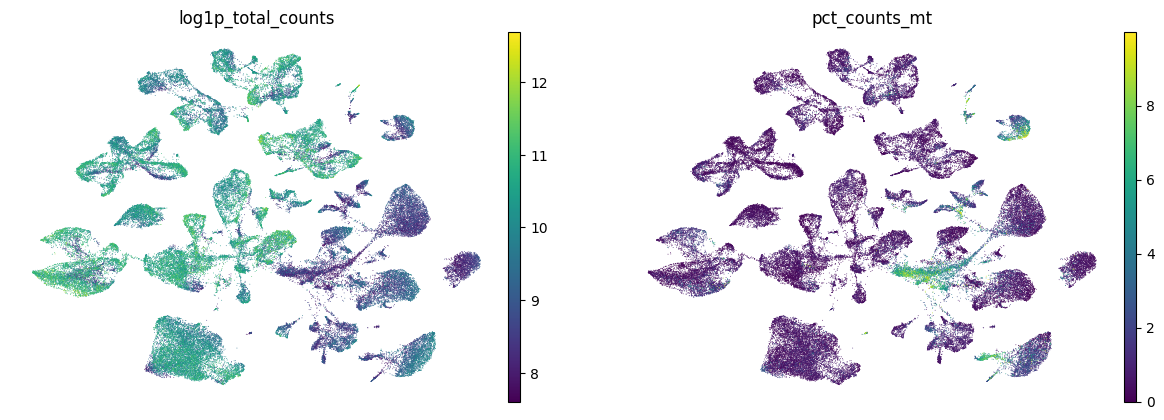

In [17]:
sc.pl.umap(
    adata_hdg,
    color=["log1p_total_counts","pct_counts_mt"],
    ncols=2,
    frameon=False,
)

In [18]:
sc.tl.leiden(adata_hdg, key_added="scvi_leiden", resolution=0.5)

/tmp/ipykernel_4185722/1712972565.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_hdg, key_added="scvi_leiden", resolution=0.5)


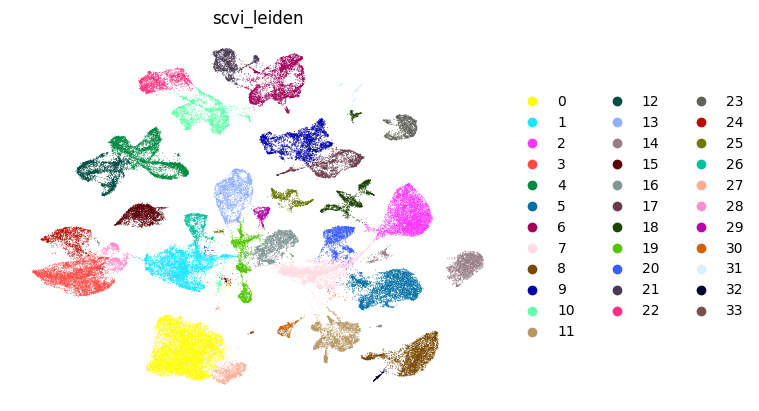

In [19]:
sc.pl.umap(
    adata_hdg,
    color=["scvi_leiden"],
    frameon=False,
)

In [20]:
adata_hdg.write_h5ad("snRNAseq_hpc/python_analysis/processed-data/adata_qc-strict_scvi-2k-hdg.h5")

In [21]:
adata_hdg.obs.to_csv("snRNAseq_hpc/python_analysis/processed-data/adata_qc-strict_scvi-2k-hdg_obs.csv")

In [22]:
import numpy as np
np.savetxt("snRNAseq_hpc/python_analysis/processed-data/adata_qc-strict_scvi-2k-hdg_umap.csv",
           adata_hdg.obsm['X_umap'], delimiter=",")